In [101]:

from dotenv import load_dotenv
import fmpsdk
import pandas as pd
import os

load_dotenv()
apikey = os.environ.get("apikey")
snp500 = pd.DataFrame(fmpsdk.sp500_constituent(apikey))

from fetch import PropertyNameList, PropertyFetcher

property_fetcher = PropertyFetcher()
key_list = [PropertyNameList.PER, PropertyNameList.PBR, PropertyNameList.PCR, PropertyNameList.DIVIDEND_YIELD,
            PropertyNameList.DEBT_RATIO, PropertyNameList.PSR]

property_fetcher.register(key_list=key_list, csv_file_directory='data/financial-ratios-quarter-20220820.csv')
property_fetcher.register(key_list=PropertyNameList.PROFILE, csv_file_directory='data/company-profile-20220827.csv')
property_fetcher.register(key_list=[PropertyNameList.MARKET_CAPITALIZATION],
                          csv_file_directory='data/market-capitalization-20220829.csv')
property_fetcher.register(key_list=[PropertyNameList.GROSS_PROFIT, PropertyNameList.EBITDA, PropertyNameList.REVENUE,
                                    PropertyNameList.NET_INCOME, PropertyNameList.TOTAL_DEBT],
                          csv_file_directory='data/financial-statements-quarter-20220829.csv')

from analyze import Analyst, TableNameList

analyst = Analyst(fetcher=property_fetcher)
analyst.register(table_name=TableNameList.STOCK_PRICE,
                 csv_file_directory='data/snp500_price_list_19620102_20220814.csv')
analyst.register(table_name=TableNameList.ECONOMIC_INDICATOR,
                 csv_file_directory='data/economic-indicators-20220828.csv')
analyst.register(table_name=TableNameList.MARKET_INDEX, csv_file_directory='data/market-index-20220826.csv')
analyst.register(table_name=TableNameList.ETC, csv_file_directory='data/etc-history-20220828.csv')



C:\Users\junbs\OneDrive\Documents\GitHub\EastFox\core\fetch.py:39: DtypeWarning: Columns (38,39,40,42,43,45,90,91,92,93,94,96,97,99,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  df_file = pd.read_csv(csv_file_directory)


In [124]:
from strategy import *

is_absolute = True
absolute_value_range_list = [(-40.0, 0), (0, 19), (20, 50), (60, 100), (100, 200)]
relative_value_range_list = [(0, 0.1), (0.2, 0.3), (0.4, 0.6), (0.8, 1.0)]

filter_list = []
target_key = PropertyNameList.MARKET_CAPITALIZATION
for relative_value_range in relative_value_range_list:
    filter_name = target_key + '=(' + str(relative_value_range[0]) + '-' + str(relative_value_range[1]) + ')'

    # absolute_selector = Selector(type=SelectorType.HORIZON_RANGE, key=target_key, value=(0.1, 1E+12), horizon=2,
    #                         is_absolute=True)

    relative_selector = Selector(type=SelectorType.HORIZON_RANGE, key=target_key, value=relative_value_range, horizon=2,
                                 is_absolute=False)
    selector_sequence = SelectorSequence(selectors=[relative_selector])
    filter_list.append(Filter(selector_sequence_union=[selector_sequence], name=filter_name))

In [127]:

from strategy import *

filter_list = []

vanilla_selector = Selector(type=SelectorType.HORIZON_RANGE, key=PropertyNameList.PBR,
                            value=(0.0, 1.0), is_absolute=False)
selector_sequence = SelectorSequence(selectors=[vanilla_selector])
filter_vanilla = Filter(selector_sequence_union=[selector_sequence], name="VANILLA")
filter_list.append(filter_vanilla)

selector_sequence = SelectorSequence(selectors=[
    Selector(type=SelectorType.PROFILE, key=PropertyNameList.SECTOR,
             value=[SelectorValue.PROFILE_SECTOR_INFORMATION_TECHNOLOGY]),
    Selector(type=SelectorType.HORIZON_RANGE, key=PropertyNameList.REVENUE,
             value=(0.7, 1.0), horizon=3, is_absolute=False),
    Selector(type=SelectorType.HORIZON_RANGE, key=PropertyNameList.PBR,
             value=(0.8, 1.0), horizon=3, is_absolute=False),
    Selector(type=SelectorType.HORIZON_RANGE, key=PropertyNameList.PCR,
             value=(0.2, 0.4), horizon=3, is_absolute=False)
])
filter_list.append(Filter(selector_sequence_union=[selector_sequence], name="JBS"))


# selector_sequence = SelectorSequence(selectors=[
#     Selector(type=SelectorType.PROFILE, key=PropertyNameList.SECTOR,
#              value=[SelectorValue.PROFILE_SECTOR_HEALTH_CARE]),
#     Selector(type=SelectorType.HORIZON_RANGE, key=PropertyNameList.DEBT_RATIO,
#     value=(0.0, 0.4), horizon=3, is_absolute=False)
# ])
# filter_list.append(Filter(selector_sequence_union=[selector_sequence], name="NOTAMONG"))


selector_sequence = SelectorSequence(selectors=[
    Selector(type=SelectorType.PROFILE, key=PropertyNameList.SYMBOL,
             value=['TSLA']),
    # Selector(type=SelectorType.HORIZON_RANGE, key=PropertyNameList.DEBT_RATIO,
    # value=(0.2, 1.0), horizon=3, is_absolute=True)
])
filter_list.append(Filter(selector_sequence_union=[selector_sequence], name="TAMONG"))


In [128]:
initial_holdings = [Asset(symbol=symbol) for symbol in snp500['symbol']]
start_date = datetime.date(2010, 7, 1)
end_date = datetime.date(2022, 8, 20)
rebalance_dates = pd.date_range(start_date, end_date, freq='1Y', inclusive='both')

strategist_list = []
for filter_ in filter_list:
    strategist_name = filter_.name
    strategist = Strategist(fetcher=property_fetcher, name=strategist_name, asset_pool=initial_holdings,
                            start_date=start_date, end_date=end_date)
    for rebalance_date in rebalance_dates:
        strategist.select_assets(filter=filter_, rebalance_date=rebalance_date.date())
    strategist_list.append(strategist)

analyst.reset()
for strategist in strategist_list:
    analyst.write_report(strategist)

analyst.update_assets_property(PropertyNameList.GROSS_PROFIT)
analyst.update_assets_property(PropertyNameList.REVENUE)


In [118]:
strategist_list[2].show_asset_selection()

,selectCounts,name,sector,subSector,headQuarter,dateFirstAdded,cik,founded
symbol,,,,,,,,
AAPL,3,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
ABT,6,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
ADI,12,Analog Devices,Information Technology,Semiconductors,"Wilmington, Massachusetts",1999-10-12,6281,1965
ADM,10,ADM,Consumer Staples,Agricultural Products,"Chicago, Illinois",1981-07-29,7084,1902
ADP,12,ADP,Information Technology,Data Processing & Outsourced Services,"Roseland, New Jersey",1981-03-31,8670,1949
...,...,...,...,...,...,...,...,...
WY,3,Weyerhaeuser,Real Estate,Specialized REITs,"Seattle, Washington",NaN,106535,1900
XEL,3,Xcel Energy,Utilities,Multi-Utilities,"Minneapolis, Minnesota",1957-03-04,72903,1909
XOM,9,ExxonMobil,Energy,Integrated Oil & Gas,"Irving, Texas",1957-03-04,34088,1999


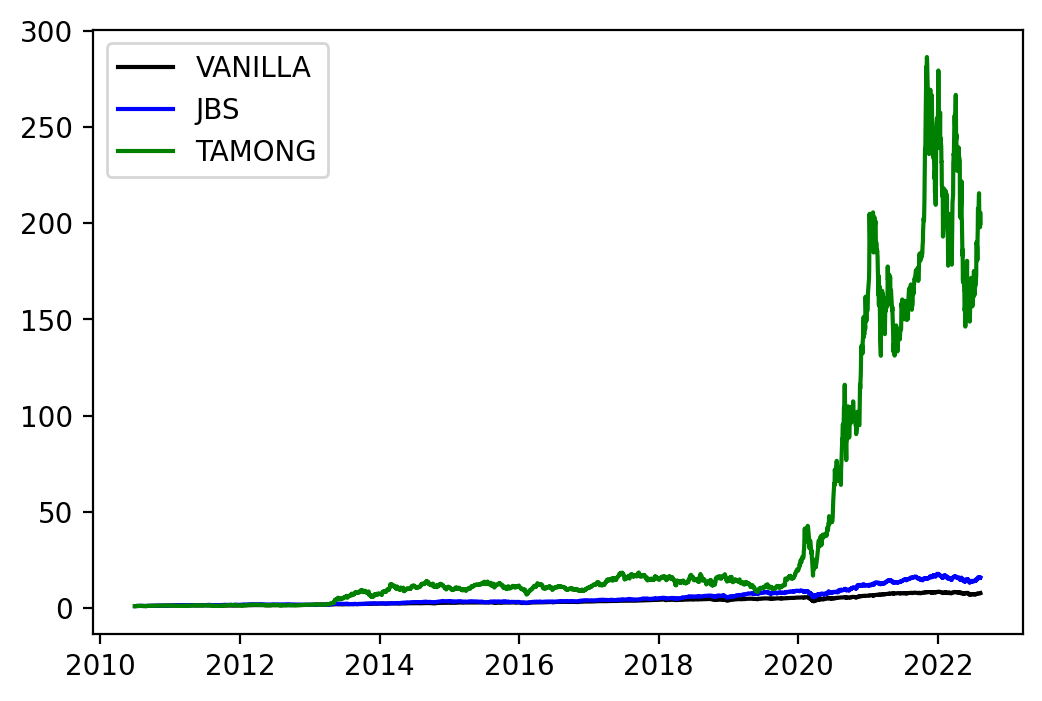

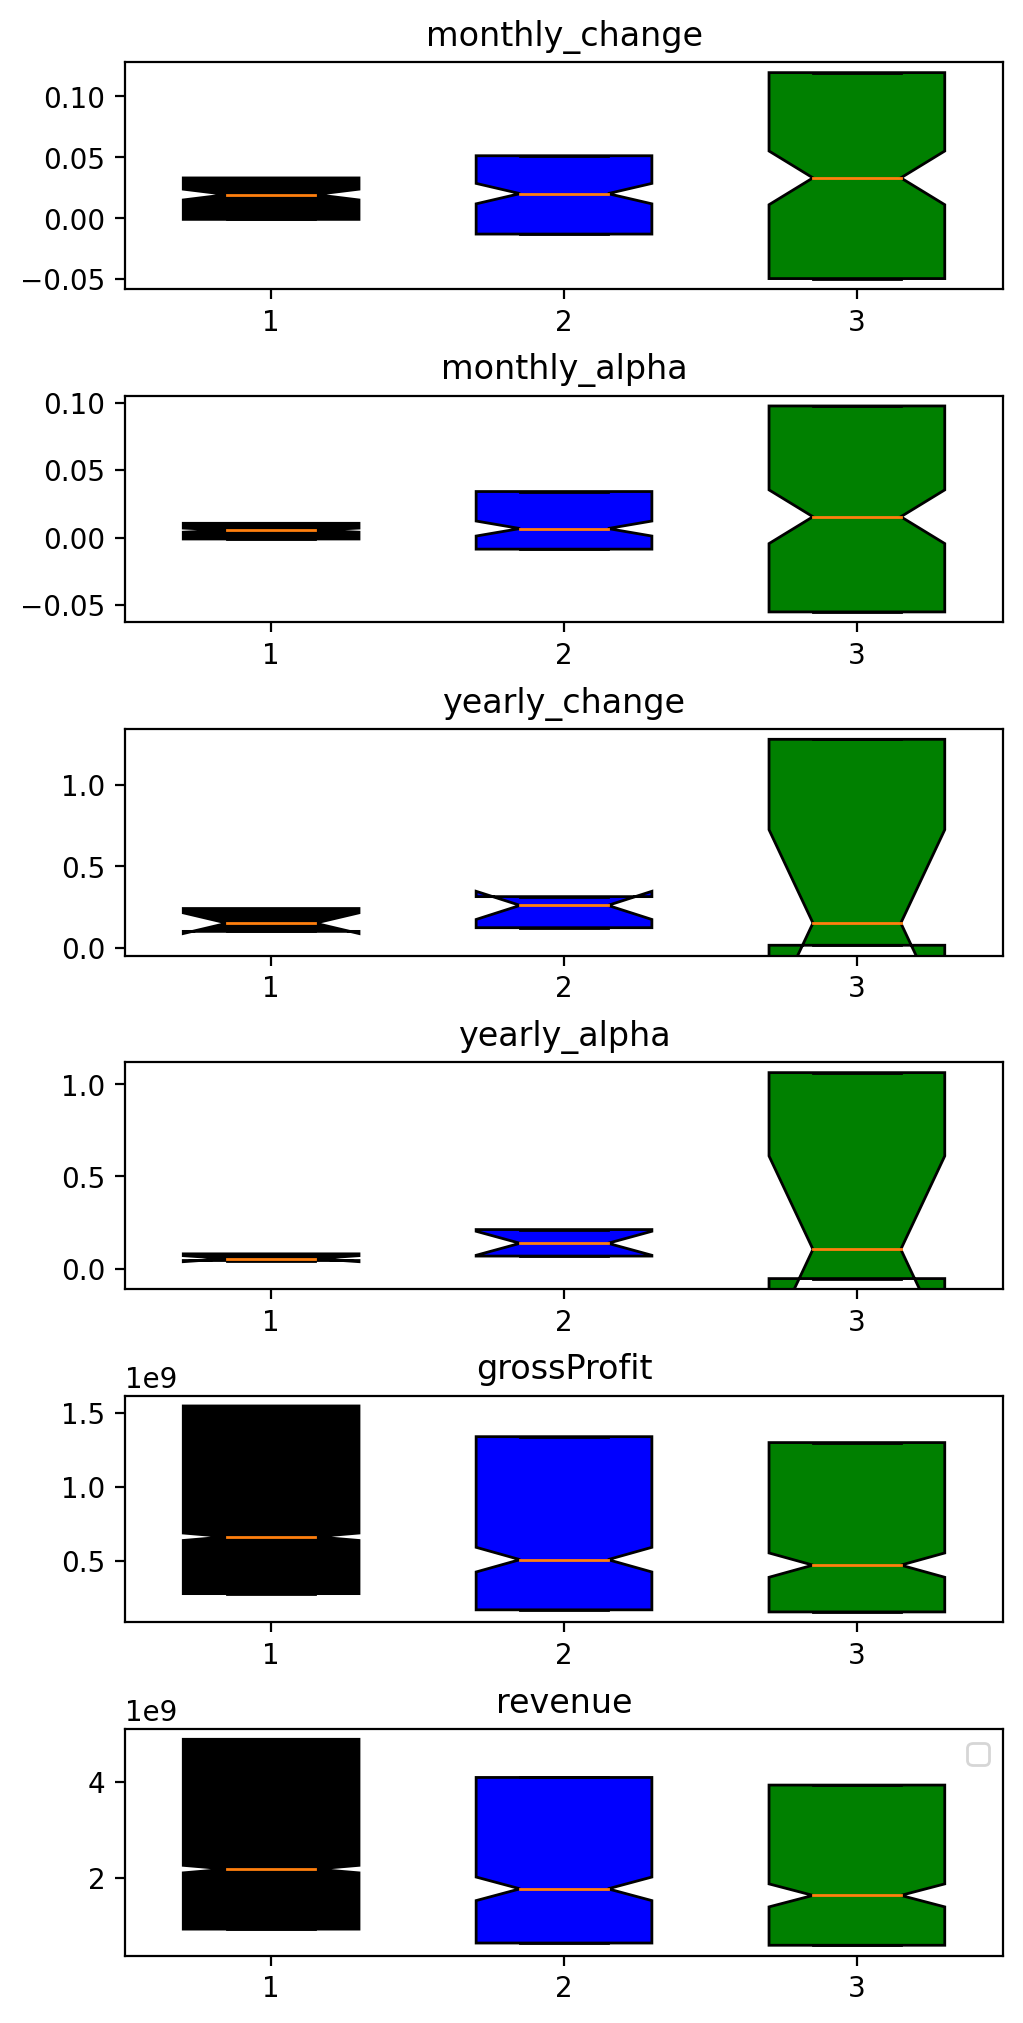

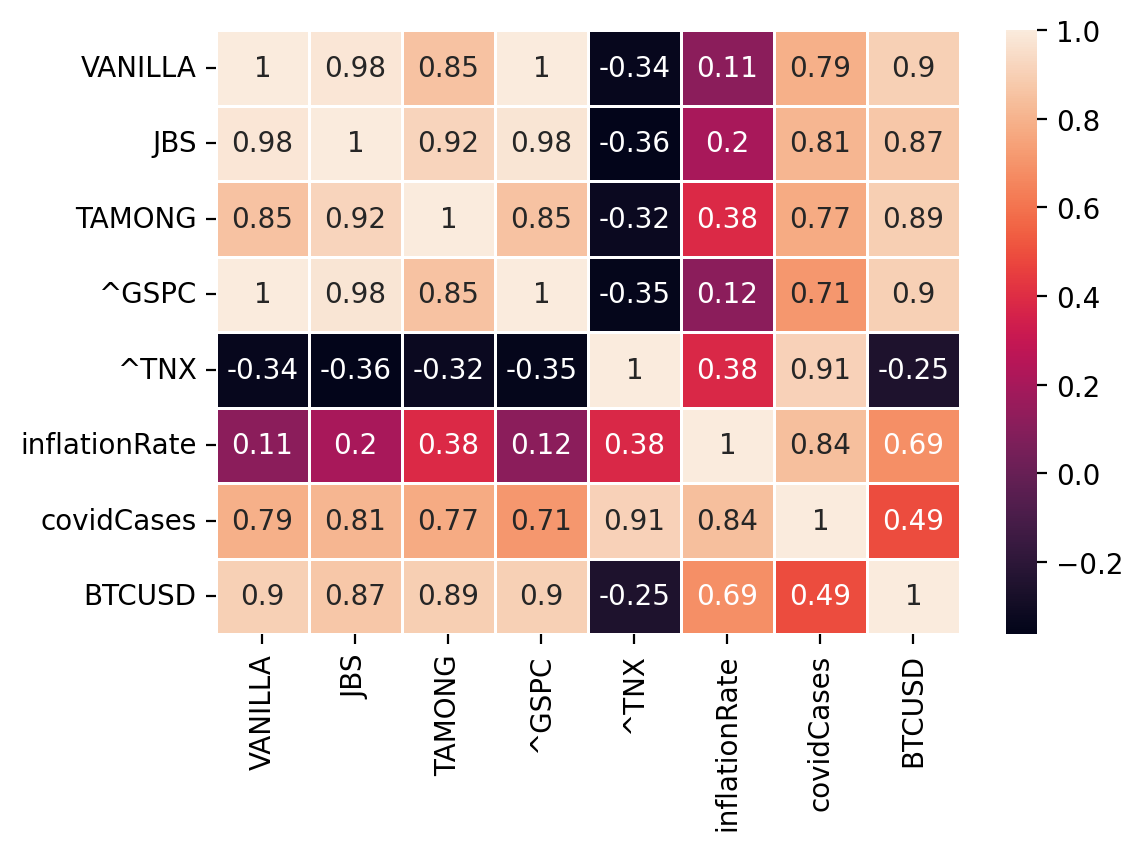

In [129]:

import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200  # default for me was 75

plt.figure(1)
analyst.draw_price_history()
plt.legend()

analyst.draw_property_distributions()
plt.legend()

from analyze import MarketIndexList, EconomicIndicatorList, EtcList
from datetime import date

target_history_list_dict = {TableNameList.MARKET_INDEX: [MarketIndexList.SNP500, MarketIndexList.TREASURY_10YEAR],
                            TableNameList.ECONOMIC_INDICATOR: [EconomicIndicatorList.INFLATION_RATE],
                            TableNameList.ETC: [EtcList.COVID, EtcList.BITCOIN]}

plt.figure(4)
analyst.draw_correlation_heatmap(target_history_list_dict, start_date, end_date)



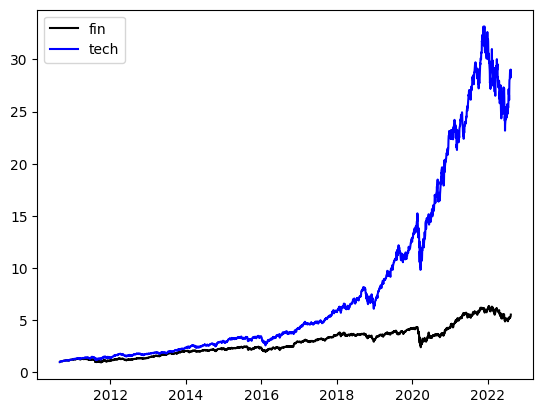

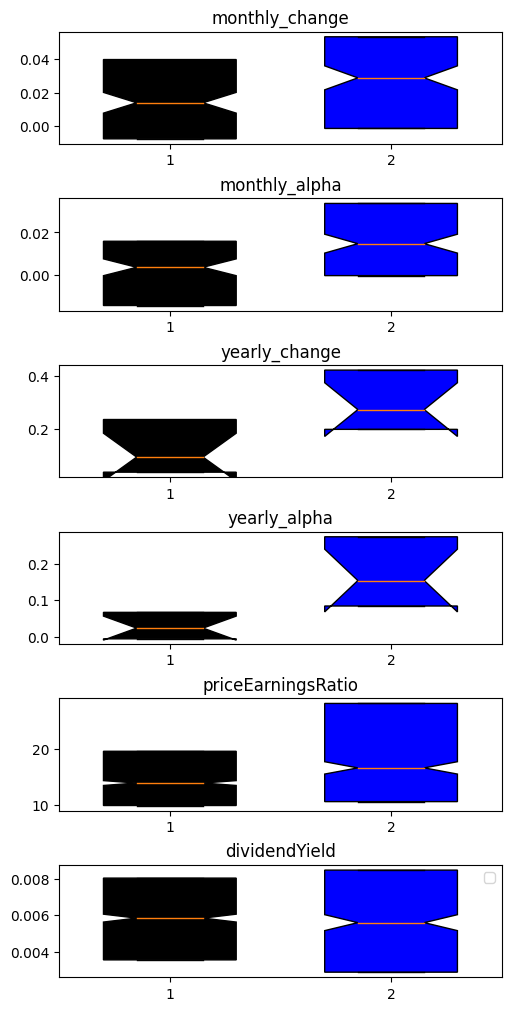

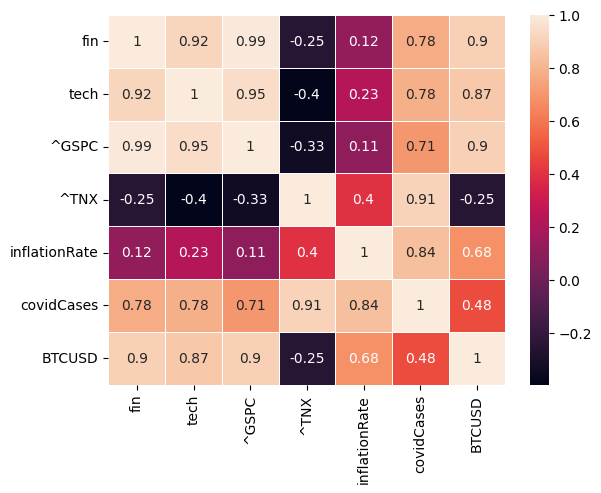

In [5]:
% matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100  # default for me was 75

plt.figure(1)
analyst.draw_price_history()
plt.legend()

analyst.draw_property_distributions()
plt.legend()

from analyze import MarketIndexList, EconomicIndicatorList, EtcList
from datetime import date

target_history_list_dict = {TableNameList.MARKET_INDEX: [MarketIndexList.SNP500, MarketIndexList.TREASURY_10YEAR],
                            TableNameList.ECONOMIC_INDICATOR: [EconomicIndicatorList.INFLATION_RATE],
                            TableNameList.ETC: [EtcList.COVID, EtcList.BITCOIN]}

plt.figure(4)
analyst.draw_correlation_heatmap(target_history_list_dict, start_date, end_date)
